In [1]:
import os
import sys
from pathlib import Path
import random
import time
import math
import csv
from types import SimpleNamespace

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# немного позовимся с импортами, чтобы внутренние импорты модели правильно работали
ROOT = Path('..').resolve()
DATA_ROOT = ROOT / 'data' / 'instereo2k_sample'
DATASETS_PY = ROOT / 'datasets'
MODELS_DIR = ROOT / 'models'
HIGH_WEIGHT = MODELS_DIR / 'high_weight'
WEIGHTS_PATH = MODELS_DIR / 'middlebury_finetune.pth'
# OUTPUT_DIR = ROOT / 'outputs' / 'teacher_results'
CORE_DIR = HIGH_WEIGHT / 'core'

OUTPUT_DIR = ROOT / 'results'

print("ROOT:", ROOT)
print("DATA_ROOT:", DATA_ROOT)
print("HIGH_WEIGHT:", HIGH_WEIGHT)
print("WEIGHTS_PATH:", WEIGHTS_PATH)
print("OUTPUT_DIR:", OUTPUT_DIR)
print("DATASETS_PY", DATASETS_PY)

os.chdir('..')
sys.path.insert(0, str(HIGH_WEIGHT))

from datasets.instereo2k import InStereo2KDataset, pil_to_tensor, load_disp_png, resize_pair_and_disp
from models.high_weight.core.igev_stereo import IGEVStereo, autocast
from models.high_weight.core.utils.utils import InputPadder

ROOT: D:\DepthAnalitycs
DATA_ROOT: D:\DepthAnalitycs\data\instereo2k_sample
HIGH_WEIGHT: D:\DepthAnalitycs\models\high_weight
WEIGHTS_PATH: D:\DepthAnalitycs\models\middlebury_finetune.pth
OUTPUT_DIR: D:\DepthAnalitycs\results
DATASETS_PY D:\DepthAnalitycs\datasets


d:\DepthAnalitycs\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


### Конфиг модели

In [3]:
cfg = SimpleNamespace()
cfg.mixed_precision = True
cfg.precision_dtype = 'float16'
cfg.hidden_dims = [128,128,128]
cfg.n_downsample = 2
cfg.n_gru_layers = 3
cfg.corr_levels = 2
cfg.corr_radius = 4
cfg.max_disp = 768
cfg.valid_iters = 80
cfg.device = device

### Логгер

In [4]:
class SimpleLogger:
    def __init__(self, out_dir: Path):
        self.out_dir = Path(out_dir)
        self.csv_file = self.out_dir / "inference_metrics.csv"
        self.fieldnames = ['id', 'time','disp_min', 'disp_mean', 'disp_max', 'pct_1px', 'pct_3px', 'saved_npy', 'saved_png']

        with open(self.csv_file, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=self.fieldnames)
            writer.writeheader()
        self.writer = None
        self.step = 0

    def log(self, rec: dict):
        with open(self.csv_file, 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=self.fieldnames)
            writer.writerow(rec)
        if self.writer is not None:
            for k,v in rec.items():
                if isinstance(v, (int, float)):
                    self.writer.add_scalar(k, float(v), self.step)
        self.step += 1
        print(rec)

logger = SimpleLogger(OUTPUT_DIR)
print("Logger ready. CSV at:", logger.csv_file)

Logger ready. CSV at: D:\DepthAnalitycs\results\inference_metrics.csv


### Импорт модели и загрузка весов

In [5]:
def strip_prefix(state_dict, prefix='module.'):
    if any(k.startswith(prefix) for k in state_dict.keys()):
        return {k[len(prefix):] if k.startswith(prefix) else k: v for k, v in state_dict.items()}
    return state_dict

ckpt_path = WEIGHTS_PATH
ckpt = torch.load(str(ckpt_path), map_location='cpu')

state = ckpt
state = strip_prefix(state, 'module.')

C:\Users\Huawei\AppData\Local\Temp\ipykernel_9428\1345366417.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(ckpt_path), map_location='cpu')


In [6]:
args = cfg

model = IGEVStereo(args)
print("Model instantiated.")
print("Total params (M): %.2f" % (sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6))

model.load_state_dict(state, strict=False)

model = model.to(device)
model.eval()

Model instantiated.
Total params (M): 13.14


IGEVStereo(
  (cnet): MultiBasicEncoder(
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

### Датасет и даталоадер

In [7]:
dataset = InStereo2KDataset(
    root_dir=str(DATA_ROOT),
    split='train',
    val_ratio=0.1,
    load_disp=True,
    disp_side='left',
    disp_divisor=100.0,
    resize_hw=(416, 608)
)
print("Dataset length:", len(dataset))

loader = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=True)

Dataset length: 351


### Функции сохранения диспаратности, расчета метрик и визуализации

In [8]:
def save_disp_out(disp: np.ndarray, out_base: Path, scale_png: float = 100.0):
    
    out_base = Path(out_base)
    out_base.parent.mkdir(parents=True, exist_ok=True)

    np.save(str(out_base.with_suffix('.npy')), disp.astype(np.float32))

    disp_fixed = np.nan_to_num(disp, nan=0.0, posinf=0.0, neginf=0.0)
    disp_scaled = np.clip(np.round(disp_fixed * scale_png), 0, 65535).astype(np.uint16)
    Image.fromarray(disp_scaled).save(str(out_base.with_suffix('.png')))

def compute_metrics(pred: np.ndarray, gt: np.ndarray, mask: np.ndarray):
    
    valid = mask.astype(bool)
    diff = np.abs(pred[valid] - gt[valid])
    dispar = pred[valid]
    epe = dispar.mean()
    epe_max = dispar.max()
    epe_min = dispar.min()
    p1 = 100.0 * (diff < 1.0).mean()
    p3 = 100.0 * (diff < 3.0).mean()
    return {'disp_min': float(epe_min),'disp_mean': float(epe),'disp_max': float(epe_max), 'pct_1px': float(p1), 'pct_3px': float(p3)}

### Pseudo-labeling

In [9]:
start_time = time.time()
model.eval()
use_mixed = cfg.mixed_precision

n_done = 0
max_to_run = 30

for i, sample in enumerate(loader):
    if max_to_run is not None and i >= max_to_run:
        break

    sid = sample['id'][0] if isinstance(sample['id'][0], str) else str(sample['id'].item())
    left = sample['left'][0].to(device)
    right = sample['right'][0].to(device)

    has_gt = 'disp' in sample

    gt_disp = sample['disp'][0].cpu().numpy()
    mask = sample['mask'][0].cpu().numpy().astype(np.uint8)

    inp_left = (left * 255.0).unsqueeze(0)
    inp_right = (right * 255.0).unsqueeze(0)

    padder = InputPadder(inp_left.shape, divis_by=32)
    inp_left_p, inp_right_p = padder.pad(inp_left, inp_right)

    t0 = time.time()
    with torch.no_grad():
        out_disp = model(inp_left_p, 
                         inp_right_p, 
                         iters=cfg.n_gru_layers,
                         test_mode=True)
    t1 = time.time()

    out_disp = padder.unpad(out_disp)
    out_disp = out_disp.squeeze(1).squeeze(0)
    pred_np = out_disp.numpy().astype(np.float32)

    base = OUTPUT_DIR / 'inferenced' /  f"{sid}"
    save_disp_out(pred_np, base, scale_png=100.0)

    metrics = {}
    mets = compute_metrics(pred_np, gt_disp, mask)
    metrics.update(mets)

    metrics_record = {
        'id': sid,
        'time': round(t1 - t0, 4),
        'disp_min': metrics['disp_min'],
        'disp_mean': metrics['disp_mean'],
        'disp_max': metrics['disp_max'],
        'pct_1px': metrics['pct_1px'],
        'pct_3px': metrics['pct_3px'],
        'saved_npy': str(base.with_suffix('.npy').name),
        'saved_png': str(base.with_suffix('.png').name)
    }
    logger.log(metrics_record)
    n_done += 1

print(f"Done {n_done} samples in {time.time() - start_time:.1f}s")

d:\DepthAnalitycs\datasets\instereo2k.py:18: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  return torch.from_numpy(arr).float().div_(255.0)
d:\DepthAnalitycs\models\high_weight\core\igev_stereo.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision, dtype=getattr(torch, self.args.precision_dtype, torch.float16)):
d:\DepthAnalitycs\.venv\lib\site-packages\torch\amp\autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but

{'id': '000659', 'time': 7.6476, 'disp_min': 23.627511978149414, 'disp_mean': 32.60590744018555, 'disp_max': 49.838287353515625, 'pct_1px': 98.82986230778069, 'pct_3px': 99.75546912182233, 'saved_npy': '000659.npy', 'saved_png': '000659.png'}
{'id': '000622', 'time': 7.3422, 'disp_min': 24.662628173828125, 'disp_mean': 36.82136535644531, 'disp_max': 51.992530822753906, 'pct_1px': 99.51901704866299, 'pct_3px': 99.99759708767026, 'saved_npy': '000622.npy', 'saved_png': '000622.png'}
{'id': '000501', 'time': 7.3017, 'disp_min': 29.513694763183594, 'disp_mean': 36.94082260131836, 'disp_max': 44.88216018676758, 'pct_1px': 90.21341078418992, 'pct_3px': 98.07404812435587, 'saved_npy': '000501.npy', 'saved_png': '000501.png'}
{'id': '000740', 'time': 7.3438, 'disp_min': 23.214263916015625, 'disp_mean': 53.4329948425293, 'disp_max': 88.02446746826172, 'pct_1px': 96.6853462730347, 'pct_3px': 99.80081371435959, 'saved_npy': '000740.npy', 'saved_png': '000740.png'}
{'id': '000727', 'time': 8.2316,

### Визуализация результата

[WindowsPath('results/inferenced/000415.npy'), WindowsPath('results/inferenced/000416.npy'), WindowsPath('results/inferenced/000456.npy'), WindowsPath('results/inferenced/000476.npy'), WindowsPath('results/inferenced/000486.npy'), WindowsPath('results/inferenced/000491.npy'), WindowsPath('results/inferenced/000501.npy'), WindowsPath('results/inferenced/000504.npy'), WindowsPath('results/inferenced/000511.npy'), WindowsPath('results/inferenced/000517.npy'), WindowsPath('results/inferenced/000523.npy'), WindowsPath('results/inferenced/000532.npy'), WindowsPath('results/inferenced/000543.npy'), WindowsPath('results/inferenced/000572.npy'), WindowsPath('results/inferenced/000578.npy'), WindowsPath('results/inferenced/000591.npy'), WindowsPath('results/inferenced/000613.npy'), WindowsPath('results/inferenced/000619.npy'), WindowsPath('results/inferenced/000622.npy'), WindowsPath('results/inferenced/000623.npy'), WindowsPath('results/inferenced/000631.npy'), WindowsPath('results/inferenced/0

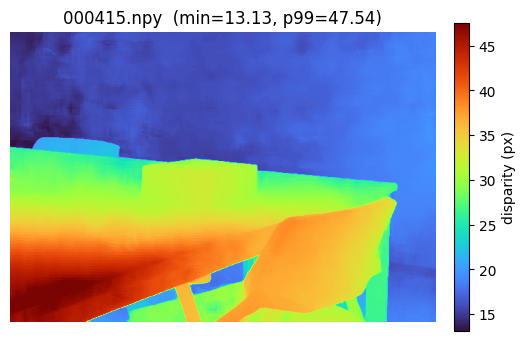

In [13]:
NPY_DIR = Path("results/inferenced")
files = sorted(NPY_DIR.glob("*.npy"))
print(files)

def show_npy_heatmap(npy_path, cmap='turbo', mask_zero=True, vmax_percentile=99.0):
    p = Path(npy_path)
    disp = np.load(p)

    valid = np.isfinite(disp)
    if mask_zero:
        valid &= (disp > 0)


    vmin = float(np.min(disp[valid]))
    vmax = float(np.percentile(disp[valid], vmax_percentile))

    plt.figure(figsize=(6,4))
    im = plt.imshow(np.ma.masked_where(~valid, disp), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(p.name + f"  (min={vmin:.2f}, p{int(vmax_percentile)}={vmax:.2f})")
    plt.axis('off')
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("disparity (px)")
    plt.show()

some_path = random.choice(files)
show_npy_heatmap(some_path)